In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras.datasets import mnist
import numpy as np
def load_az_dataset(dataset_path):
    # initialize the list of data and labels
    data = []
    labels = []

    # loop over the rows of the A-Z handwritten digit dataset
    for row in open(dataset_path):
        # parse the label and image from the row
        row = row.split(",")
        # print(row)
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")

        # images are represented as single channel (grayscale) images
        # that are 28x28=784 pixels -- we need to take this flattened
        # 784-d list of numbers and reshape them into a 28x28 matrix
        image = image.reshape((28, 28))

        # update the list of data and labels
        data.append(image)
        labels.append(label)

        # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")

    # return a 2-tuple of the A-Z data and labels
    return (data, labels)


def load_zero_nine_dataset():
    # load the MNIST dataset and stack the training data and testing
    # data together (we'll create our own training and testing splits
    # later in the project)
    ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabels, testLabels])
    # return a 2-tuple of the MNIST data and labels
    return (data, labels)


In [ ]:
# from .resnet import ResNet

In [4]:
# import the necessary packages

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False,
                        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # the shortcut branch of the ResNet module should be
        # initialize as the input (identity) data
        shortcut = data

        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(data)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
                       kernel_regularizer=l2(reg))(act1)

        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
                       padding="same", use_bias=False,
                       kernel_regularizer=l2(reg))(act2)

        # the third block of the ResNet module is another set of 1x1
        # CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias=False,
                       kernel_regularizer=l2(reg))(act3)

        # if we are to reduce the spatial size, apply a CONV layer to
        # the shortcut
        if red:
            shortcut = Conv2D(K, (1, 1), strides=stride,
                              use_bias=False, kernel_regularizer=l2(reg))(act1)

        # add together the shortcut and the final CONV
        x = add([conv3, shortcut])

        # return the addition as the output of the ResNet module
        return x

    # 32, 32, 1, len(le.classes_), (3, 3, 3), (64, 64, 128, 256), reg=0.0005

    @staticmethod
    def build(width, height, depth, classes, stages, filters,
              reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # set the input and apply BN
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(inputs)

        # check if we are utilizing the CIFAR dataset
        if dataset == "cifar":
            # apply a single CONV layer
            x = Conv2D(filters[0], (3, 3), use_bias=False,
                       padding="same", kernel_regularizer=l2(reg))(x)

        # check to see if we are using the Tiny ImageNet dataset
        elif dataset == "tiny_imagenet":
            # apply CONV => BN => ACT => POOL to reduce spatial size
            x = Conv2D(filters[0], (5, 5), use_bias=False,
                       padding="same", kernel_regularizer=l2(reg))(x)
            x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                   momentum=bnMom)(x)
            x = Activation("relu")(x)
            x = ZeroPadding2D((1, 1))(x)
            x = MaxPooling2D((3, 3), strides=(2, 2))(x)

        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride,
                                       chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1],
                                           (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

        # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)

        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name="resnet")

        # return the constructed network architecture
        return model


In [6]:
# set the matplotlib backend so figures can be saved in the background
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from models import ResNet
# from typing_extensions import Required
import matplotlib
# matplotlib.use("Agg")
# from utils import load_az_dataset
# from utils import load_zero_nine_dataset

# import the necessary packages

# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()

# ap.add_argument("-a", "--az", required=True, help="path to A-Z dataset")
# ap.add_argument("-m", "--model", type=str, required=True,
#                 help="path to output the trained handwriting recognition model")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
#                 help="path to output the training history file")

# args = vars(ap.parse_args())

# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 50
INIT_LR = 1e-1
BS = 128

# load the A-Z and MNIST datasets, respectively

print("[INFO] loading datasets...")

(azData, azLabels) = load_az_dataset("/content/drive/MyDrive/Project/A_Z Handwritten Data.csv")
# print(azLabels)
(digitsData, digitsLabels) = load_zero_nine_dataset()

# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10


# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

# convert the labels from integers to vectors
le = LabelBinarizer()

labels = le.fit_transform(labels)
ounts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels, test_size=0.20, stratify=None, random_state=42)
(trainX, validX, trainY,validY) = train_test_split(trainX,trainY,test_size=0.1,stratify=None, random_state=42)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=10, zoom_range=0.05, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.15, horizontal_flip=False, fill_mode="nearest")


[INFO] loading datasets...


In [9]:
import keras
model_save_path = "/content/drive/MyDrive/Project/"
checkpoint = keras.callbacks.ModelCheckpoint(model_save_path+'checkpoint_{epoch:02d}', save_freq='epoch')
# checkpoint = keras.callbacks.ModelCheckpoint('model{epoch:08d}.h5', save_freq==5)

In [8]:
# initialize and compile our deep neural network
print("[INFO] compiling model...")

opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# data, K, stride, chanDim, red=False, reg=0.0001, bnEps=2e-5, bnMom=0.9

# width, height, depth, classes, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"

model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
                     (64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy",
              optimizer=opt, metrics=["accuracy"])
model.summary()


[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 1)   4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   576         ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 64)  256         ['conv2d[0][0]']            

In [25]:
# train the network
print("[INFO] training network...")

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS), validation_data=(validX, validY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS,
    class_weight=classWeight,
    verbose=1,callbacks=[checkpoint])

[INFO] training network...
Epoch 1/50
2488/2488 [==============================] - 185s 73ms/step - loss: 1.9358 - accuracy: 0.8646 - val_loss: 0.5815 - val_accuracy: 0.8613
Epoch 2/50
2488/2488 [==============================] - 177s 71ms/step - loss: 0.9470 - accuracy: 0.9264 - val_loss: 0.4957 - val_accuracy: 0.9146
Epoch 3/50
2488/2488 [==============================] - 181s 73ms/step - loss: 0.8718 - accuracy: 0.9340 - val_loss: 0.5470 - val_accuracy: 0.8853
Epoch 4/50
2488/2488 [==============================] - 177s 71ms/step - loss: 0.8303 - accuracy: 0.9367 - val_loss: 0.6244 - val_accuracy: 0.8536
Epoch 5/50
2488/2488 [==============================] - 177s 71ms/step - loss: 0.7978 - accuracy: 0.9388 - val_loss: 0.5614 - val_accuracy: 0.8748
Epoch 6/50
2488/2488 [==============================] - 177s 71ms/step - loss: 0.7767 - accuracy: 0.9405 - val_loss: 0.5268 - val_accuracy: 0.8926
Epoch 7/50
2488/2488 [==============================] - 177s 71ms/step - loss: 0.7615 - acc

In [10]:
# Loads the weights
# model = create_model()
model.load_weights("/content/drive/MyDrive/Project/checkpoint_50")

# Re-evaluate the model
loss, acc = model.evaluate(testX, testY, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

2766/2766 - 27s - loss: 0.3712 - accuracy: 0.9676 - 27s/epoch - 10ms/step
Restored model, accuracy: 96.76%


In [11]:
loss, acc = model.evaluate(trainX, trainY, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

9956/9956 - 61s - loss: 0.3622 - accuracy: 0.9697 - 61s/epoch - 6ms/step
Restored model, accuracy: 96.97%


In [12]:
loss, acc = model.evaluate(validX, validY, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

1107/1107 - 7s - loss: 0.3710 - accuracy: 0.9681 - 7s/epoch - 6ms/step
Restored model, accuracy: 96.81%


In [ ]:
%matplotlib inline
# save the model to disk
# print()
# model.save(args["model"], save_format="h5")

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Trainning Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
%matplotlib inline
# save the model to disk
# print()
# model.save(args["model"], save_format="h5")

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Trainning Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/Project/save_model.model',save_format="h5")

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/MyDrive/Project/save_model.model')

In [15]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow


[INFO] loading handwriting OCR model...
[INFO] H - 99.82%
[INFO] W - 99.84%
[INFO] E - 86.45%
[INFO] L - 98.31%
[INFO] D - 61.31%
[INFO] L - 99.04%
[INFO] R - 99.40%
[INFO] D - 94.87%
[INFO] L - 71.82%
[INFO] D - 98.27%


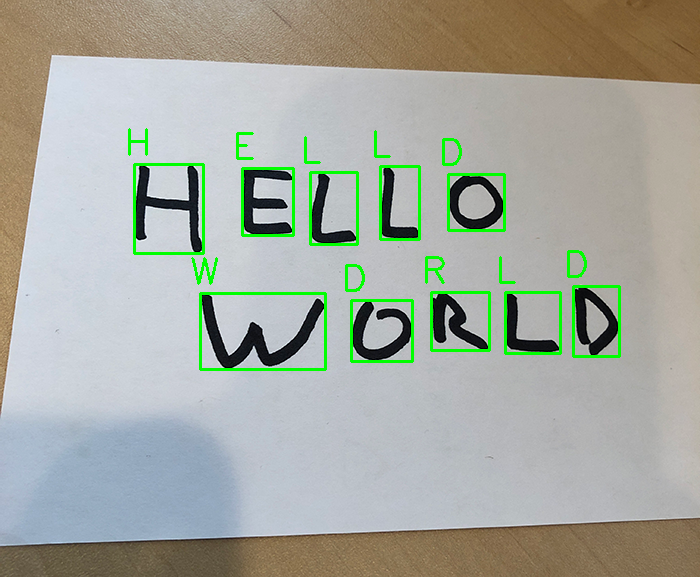

-1

In [19]:
print("[INFO] loading handwriting OCR model...")
# model = load_model(args["model"])

# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread("/content/drive/MyDrive/Project/hello_world.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)

		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)

		# re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)

		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)

		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

# print(chars)
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]

	# draw the prediction on the image
	print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(image, label, (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

# show the image
cv2_imshow(image)
cv2.waitKey(0)